# <font color=4CBB17>**Análisis exploratorio y Preprocesamiento**</font>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/cod/LEA3_health_7')

In [3]:
#!pip install tensorflow

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
import _funciones as fn
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
import itertools

In [4]:
# Ejecutar funciones para cargar los datos

extract_to = fn.cargar_zip('/content/drive/MyDrive/cod/LEA3_health_7/data/HAM10000_images_part_1.zip',
                           '/content/drive/MyDrive/cod/LEA3_health_7/data/HAM10000_images_part_2.zip',
                           '/content/ham10000_images')

imageid_path_dict = fn.crear_diccionario(extract_to)

skin_df = fn.cargar_csv('/content/drive/MyDrive/cod/LEA3_health_7/data/HAM10000_metadata.csv')

# Datos cargados
print(skin_df.head())
print(f"Total de imágenes encontradas: {len(imageid_path_dict)}")

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear
Total de imágenes encontradas: 10015


In [5]:
# Columnas con nulos
print(skin_df[skin_df.columns[skin_df.isnull().any()]].isnull().sum())

age    57
dtype: int64


In [6]:
print(f"Número de duplicados: {skin_df.duplicated().sum()}")

Número de duplicados: 0


Primera visualización de los siete tipos de lesiones cutáneas presentes en el dataframe

<Axes: ylabel='dx'>

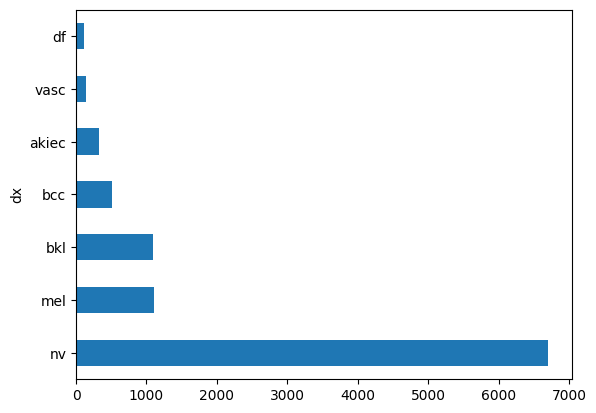

In [7]:
skin_df['dx'].value_counts().plot(kind='barh')

In [8]:
# Se usa un diccionario para poner los nombres completos a cada abreviatura
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

De acuerdo con lo anterior y considerando que el problema de negocio está enfocado en el retraso de las citas dermatológicas especializadas, se concluye que predecir el tipo específico de lesión no aporta un valor adicional relevante. En cambio, el objetivo principal es apoyar el diagnóstico inicial mediante un modelo de clasificación, por lo que resulta más útil y prioritario identificar la probabilidad de que una lesión sea maligna.

Por ello, se va a realizar una recodificación de la variable original agrupando las lesiones en dos categorías, de acuerdo con su naturaleza clínica:

* Clase 1 (lesiones malignas):
Actinic keratoses, Basal cell carcinoma, Melanoma

* Clase 0 (lesiones benignas):
Melanocytic nevi, Dermatofibroma, Benign keratosis-like lesions, Vascular lesions

Con esta transformación se busca simplificar el problema de clasificación, convirtiéndolo en un escenario binario, lo que facilita la interpretación de los resultados para tomar acciones más rápidas.

Dado que se trabajará con imágenes, surge la necesidad de definir la resolución con la que se procesarán. Esto permite una mayor eficiencia computacional y una reducción en el tiempo de entrenamiento, sin sacrificar significativamente la calidad de la información visual relevante para el modelo.

Por lo anterior, se procede a visualizar una imágen al azar, con el fin de verificar su calidad, y definir como se redimensionará.

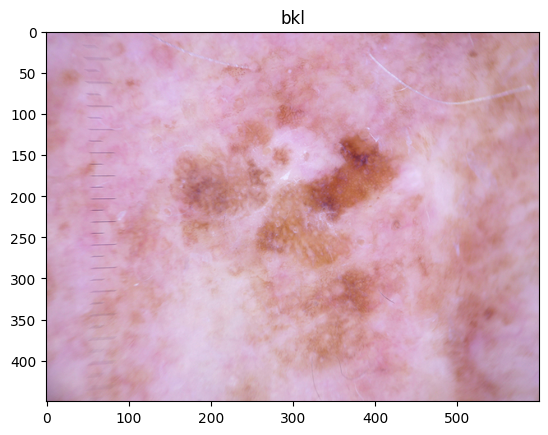

In [9]:
import cv2
import matplotlib.pyplot as plt

# Definir la carpeta donde están las imágenes
carpeta_imagenes = '/content/ham10000_images'

# Obtener el ID de la imagen
image_id = 'ISIC_0027419'

# Construir la ruta completa de la imagen
ruta_imagen = os.path.join(carpeta_imagenes, f'{image_id}.jpg')

# Leer la imagen con OpenCV (en BGR)
img_cv2 = cv2.imread(ruta_imagen)

# Convertir a RGB para mostrarla correctamente con matplotlib
img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)

# Mostrarla
plt.imshow(img_rgb)
plt.title('bkl')
plt.show()

In [10]:
img_rgb.shape

(450, 600, 3)

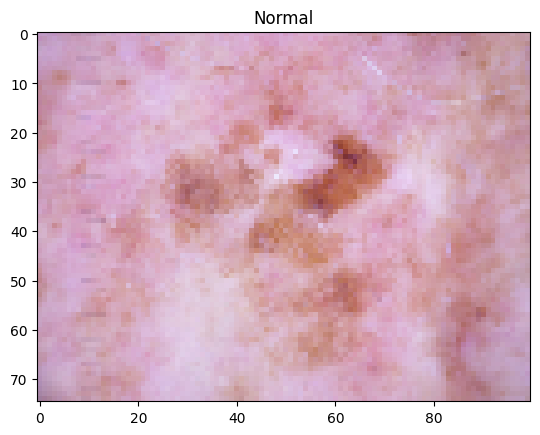

np.int64(22500)

In [11]:
img2_r = cv2.resize(img_rgb ,(100,75))
plt.imshow(img2_r)
plt.title('Normal')
plt.show()
np.prod(img2_r.shape)


En una consulta realizada a dos médicos cercanos, se estableció que, para contar con un buen criterio de valoración clínica, es fundamental observar detalles como los bordes regulares, la tonalidad, los relieves (elevaciones o depresiones), la descamación y la presencia de vasos sanguíneos alrededor de la lesión. Al mostrarles las imágenes en dos resoluciones diferentes (100x75 y 125x100), ambos coincidieron en que la segunda alternativa ofrece una mejor percepción visual, ya que la primera se ve un poco más pixelada, dificultando la evaluación de los detalles mencionados. Sin embargo, se va a redimensionar las imágenes 100 x 75, ya que esto nos ofrece una calidad decente al estar limitados de recursos.

A partir de lo anterior, se preprocesará el dataframe skin_df mediante un pipeline, en el cual se creará la ruta de cada imagen, se generará la codificación binaria para cada tipo de lesión, se eliminarán los valores nulos y se redimensionarán las imágenes."

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

pipeline_total = Pipeline(steps=[
    ('Ruta', FunctionTransformer(lambda df: fn.crear_ruta(df, imageid_path_dict, lesion_type_dict), validate=False)),
    ('Binaria', FunctionTransformer(fn.crear_binaria, validate=False)),
    ('Nulos', FunctionTransformer(lambda df: fn.reemplazar_nulos(df, columna='age'), validate=False)),
    ('Imagen', FunctionTransformer(lambda df: fn.redimensionar_imagen(df, size=(100, 75)), validate=False))
])

skin_df = pipeline_total.fit_transform(skin_df)

In [13]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0027419.jpg,Benign keratosis-like lesions,0,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0025030.jpg,Benign keratosis-like lesions,0,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0026769.jpg,Benign keratosis-like lesions,0,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0025661.jpg,Benign keratosis-like lesions,0,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/ham10000_images/ISIC_0031633.jpg,Benign keratosis-like lesions,0,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


In [14]:
skin_df.tail()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,/content/ham10000_images/ISIC_0033084.jpg,Actinic keratoses,1,"[[[155, 137, 148], [154, 136, 147], [151, 134,..."
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,/content/ham10000_images/ISIC_0033550.jpg,Actinic keratoses,1,"[[[5, 6, 4], [6, 7, 4], [7, 8, 6], [7, 7, 5], ..."
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,/content/ham10000_images/ISIC_0033536.jpg,Actinic keratoses,1,"[[[112, 102, 105], [127, 116, 117], [141, 127,..."
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,/content/ham10000_images/ISIC_0032854.jpg,Actinic keratoses,1,"[[[158, 122, 146], [159, 122, 141], [154, 112,..."
10014,HAM_0003521,ISIC_0032258,mel,histo,70.0,female,back,/content/ham10000_images/ISIC_0032258.jpg,Melanoma,1,"[[[178, 146, 132], [176, 143, 132], [177, 144,..."


In [15]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx      int64
image             object
dtype: object


In [16]:
# Lista ordenada con los nombres únicos de los tipos de lesión en la columna cell_type
categorias = pd.Categorical(skin_df['cell_type']).categories
categorias

Index(['Actinic keratoses', 'Basal cell carcinoma',
       'Benign keratosis-like lesions ', 'Dermatofibroma', 'Melanocytic nevi',
       'Melanoma', 'Vascular lesions'],
      dtype='object')

In [17]:
# Se revisa la imagen para confirmar cada dimensión (alto, ancho, canales)

skin_df['image'].map(lambda x: x.shape).value_counts()

,count
image,
"(75, 100, 3)",10015


## <font color=FF7F50>**Distribución de los tipos de lesiones**</font>

<Axes: ylabel='cell_type'>

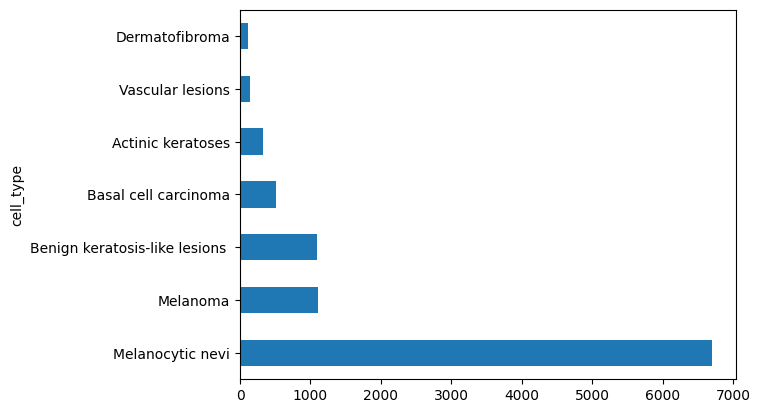

In [18]:
# Misma de arriba pero con nombres completos
skin_df['cell_type'].value_counts().plot(kind='barh')

<Axes: xlabel='cell_type_idx'>

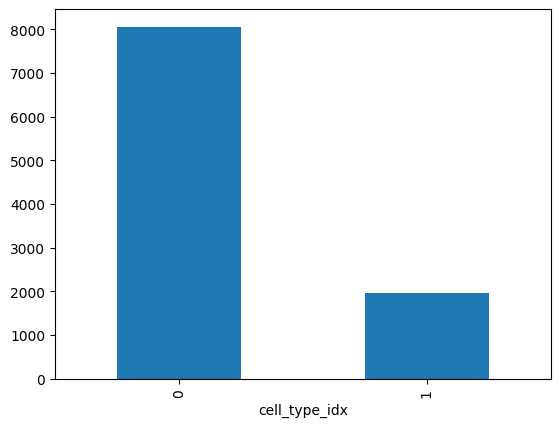

In [19]:
# Tipo de lesión (maligna y benigna)
skin_df['cell_type_idx'].value_counts().plot(kind='bar')

## <font color=FF7F50>**Distribución por sexo**</font>

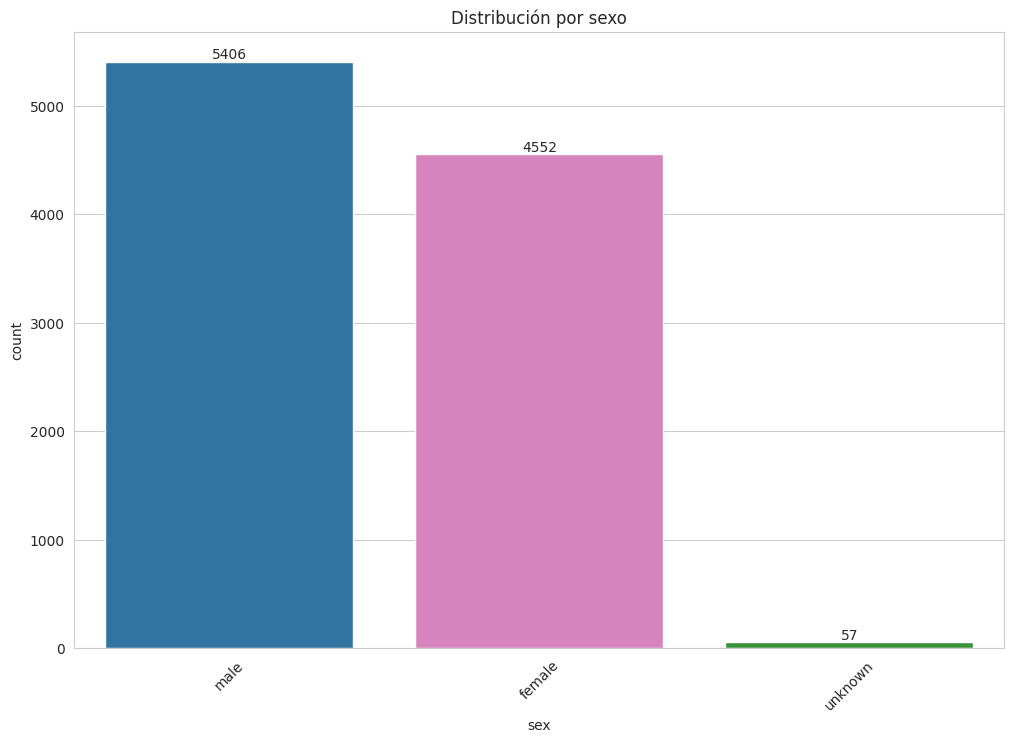

In [20]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(figsize=(12, 8))

colores = ['#1f77b4', '#e377c2', '#2ca02c']

ax = sns.countplot(x='sex', hue='sex', data=skin_df, palette=colores)
for container in ax.containers:
    ax.bar_label(container)

plt.title('Distribución por sexo')
plt.xticks(rotation=45)
plt.show()

Se observa una mayor cantidad de hombres que mujeres en el conjunto de datos; sin embargo, la diferencia entre ambos sexos no es considerablemente amplia.

## <font color=FF7F50>**Tipo de lesión por sexo**</font>



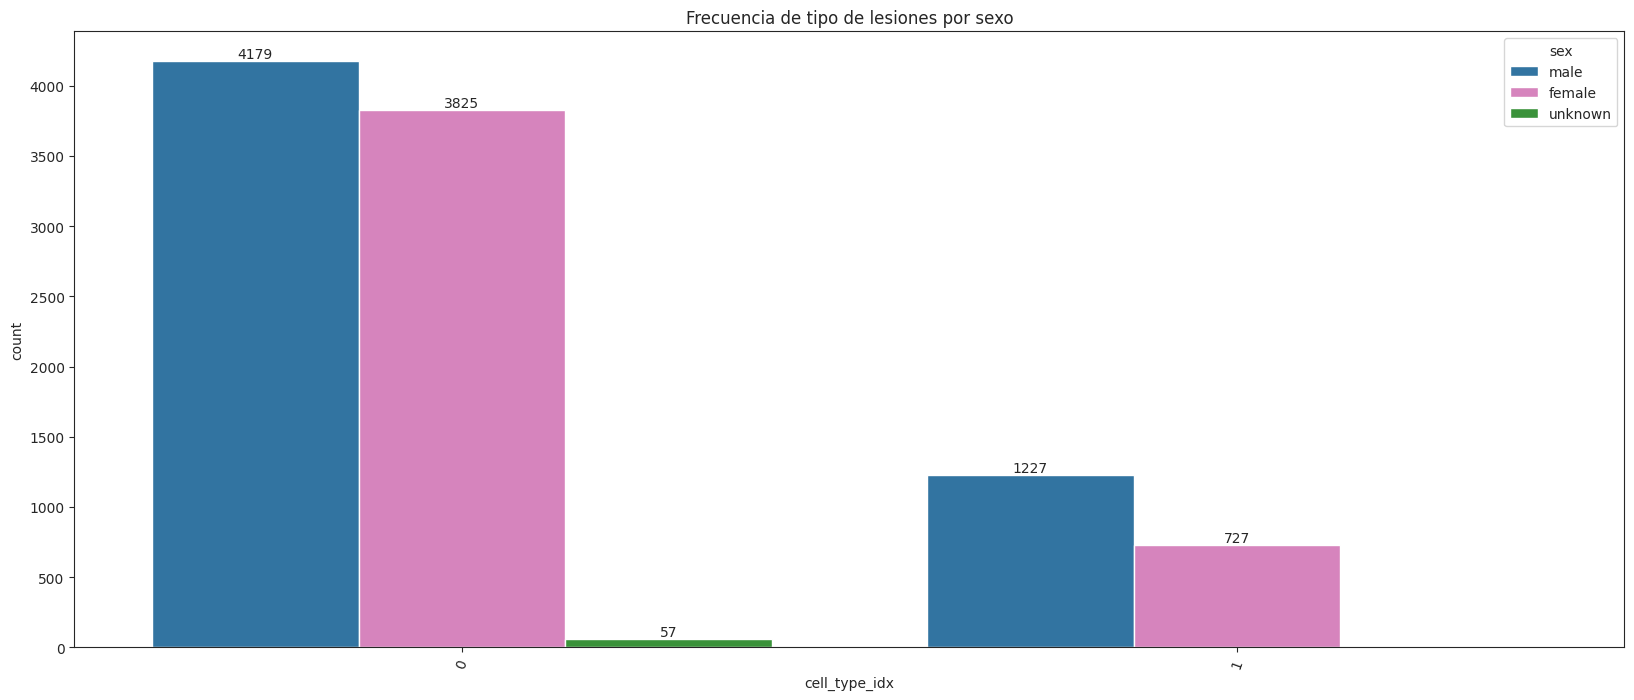

In [21]:
sns.set_style('ticks')
fig,axes = plt.subplots(figsize=(20,8))
ax = sns.countplot(x='cell_type_idx',hue='sex', data=skin_df, order = skin_df['cell_type_idx'].value_counts().index, palette = colores)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Frecuencia de tipo de lesiones por sexo')
plt.xticks(rotation=70)
plt.show()

En el grupo de lesiones benignas, no se observa una diferencia marcada entre hombres y mujeres. Sin embargo, al analizar los casos de lesiones malignas (1,954), se evidencia una mayor proporción en hombres, quienes representan el 63% de los diagnósticos, frente al 37% correspondiente a mujeres.

Es importante tener en cuenta que, del total de 9.958 pacientes clasificados según sexo, 5,406 son hombres (54.3%) y 4.552 son mujeres (45.7%). Por lo tanto, aunque los hombres constituyen una ligera mayoría en el conjunto de pacientes, su participación en los casos malignos es significativamente mayor, lo que sugiere una posible asociación entre el sexo masculino y una mayor incidencia de este tipo de lesiones.



## <font color=FF7F50>**Localización de las lesiones cutáneas**</font>


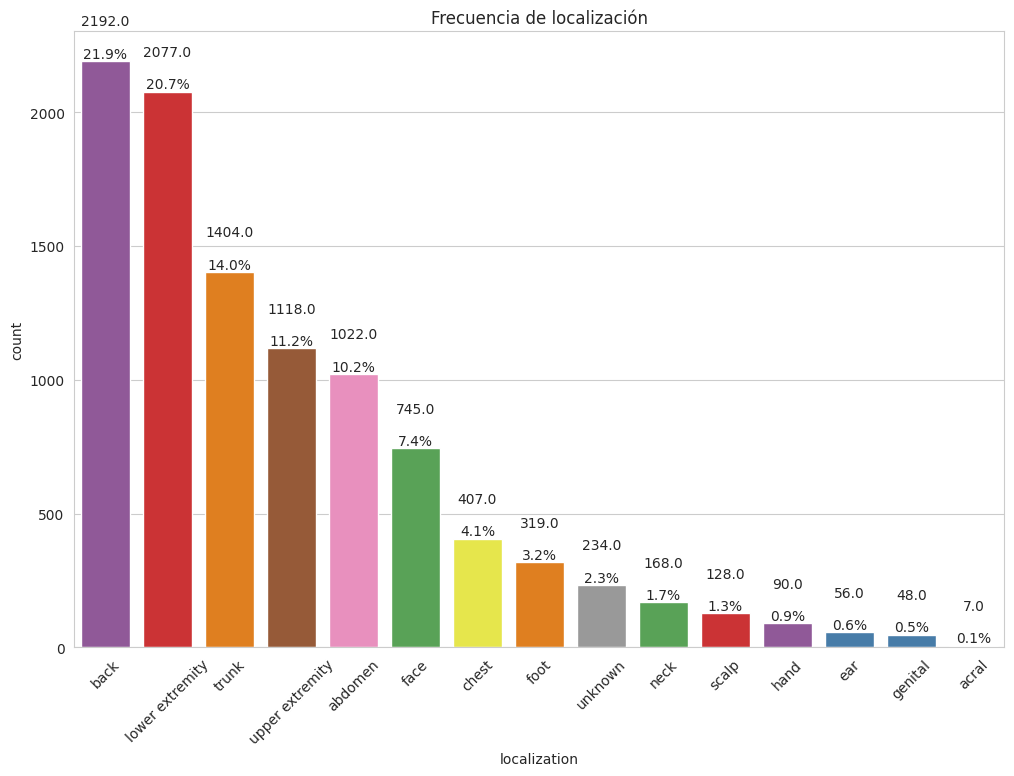

In [22]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
total = len(skin_df)

ax = sns.countplot(x='localization',hue='localization', data=skin_df, order = skin_df['localization'].value_counts().index, palette = 'Set1')
for container in ax.containers:
    labels = [f'{v.get_height()}\n\n{(v.get_height()/total)*100:.1f}%' for v in container]
    ax.bar_label(container, labels=labels)

plt.title('Frecuencia de localización')
plt.xticks(rotation=45)
plt.show()


Se observa que la ubicación más frecuente de las lesiones se encuentra en la espalda, el tren inferior, el torso y el tren superior. Esto podría estar asociado a varios factores:

* Son áreas que suelen estar expuestas al sol con mayor frecuencia, lo que incrementa el riesgo de daño cutáneo y la aparición de lesiones.

* Estas regiones ocupan una mayor superficie del cuerpo, lo que aumenta la probabilidad de que presenten alteraciones dermatológicas.

* La espalda, en particular, no suele ser revisada con regularidad por las personas, lo que retrasa la detección de anomalías y favorece la acumulación de lesiones visibles solo durante exámenes médicos.

* Las extremidades están más expuestas a traumatismos, fricción con la ropa o contacto con superficies, lo que puede desencadenar o agravar ciertos tipos de lesiones.

## <font color=FF7F50>**Localización por tipo de lesión (maligna y benigna)**</font>


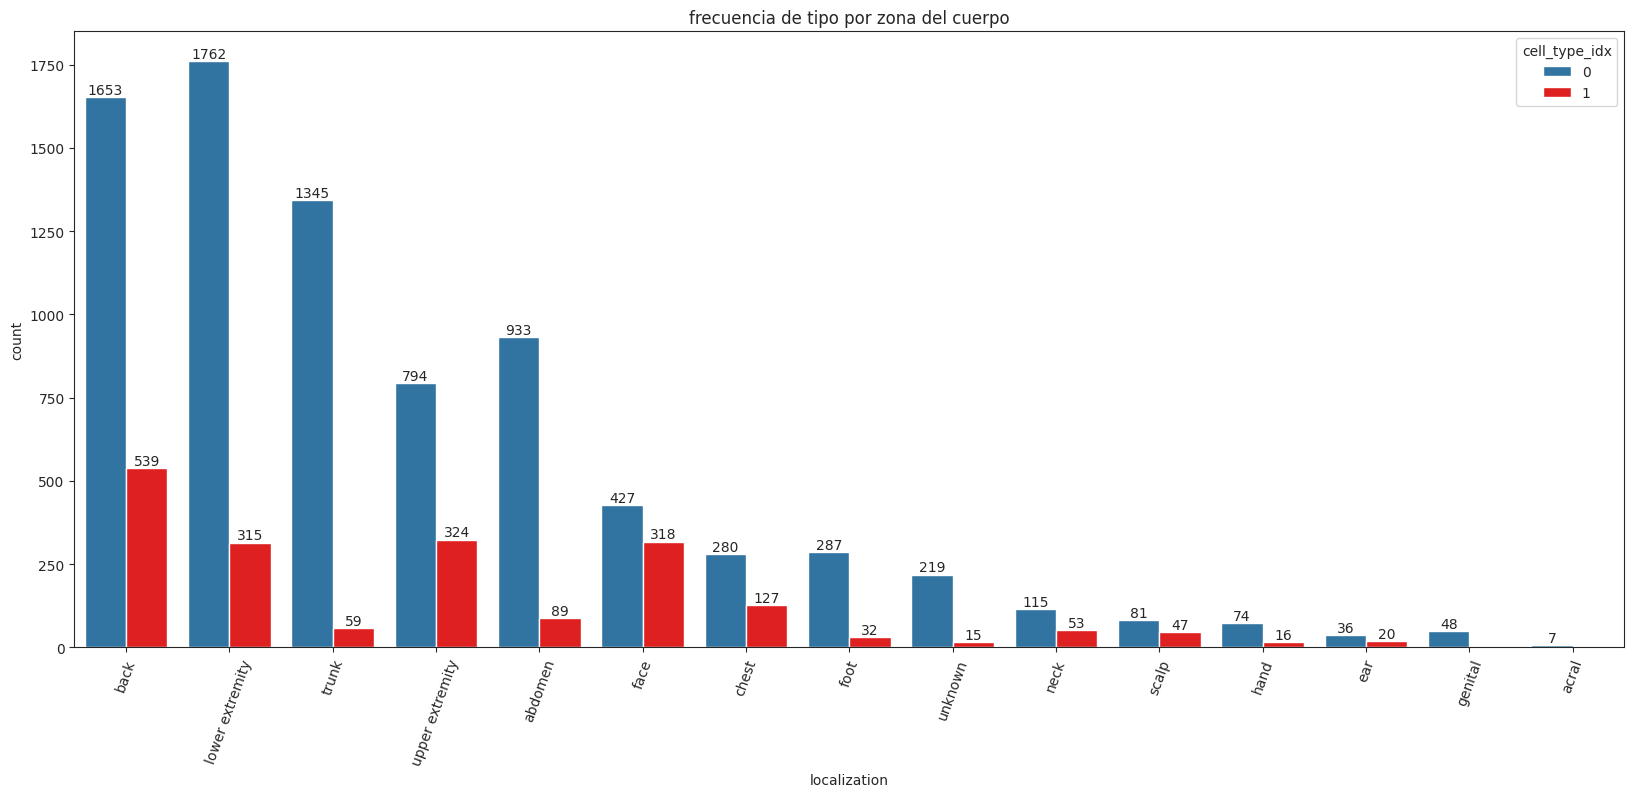

In [23]:
sns.set_style('ticks')
fig,axes = plt.subplots(figsize=(20,8))
ax = sns.countplot(x='localization',hue='cell_type_idx', data=skin_df, order = skin_df['localization'].value_counts().index, palette =['#1f77b4', 'red'])
for container in ax.containers:
    ax.bar_label(container)
plt.title('frecuencia de tipo por zona del cuerpo')
plt.xticks(rotation=70)
plt.show()

Se observa que las lesiones ubicadas en la cara tienen una mayor probabilidad de ser cancerosas en comparación con otras partes del cuerpo, como el tronco, las extremidades inferiores o el abdomen.
También es relevante señalar que el cuero cabelludo (scalp), la oreja (ear) y el cuello (neck) son zonas que presentan una incidencia notable de este tipo de lesiones malignas.

## <font color=FF7F50>**Tipo de examen por el que se confirmo el tipo de lesión**</font>

* Histo (Histopatología):
Diagnóstico basado en el análisis microscópico de una muestra de tejido. Es considerado el método más preciso para identificar lesiones malignas.

* Follow-up (Seguimiento):
Diagnóstico determinado a partir de la observación clínica de la evolución de la lesión a lo largo del tiempo, sin intervención inmediata.

* Consensus (Consenso clínico):
Diagnóstico acordado por varios dermatólogos expertos al evaluar conjuntamente las imágenes o características clínicas de la lesión.

* Confocal (Microscopía confocal):
Diagnóstico realizado mediante imágenes de alta resolución obtenidas con microscopía láser confocal, una técnica no invasiva que permite observar estructuras celulares en la piel en tiempo real.

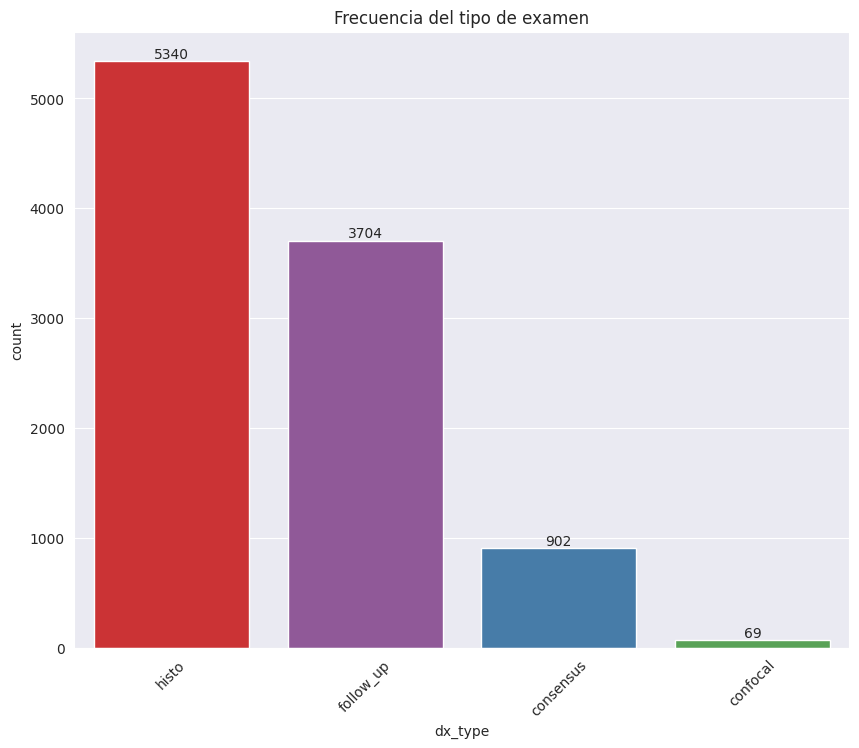

In [24]:
sns.set_style('darkgrid')
fig,axes = plt.subplots(figsize=(10,8))
ax = sns.countplot(x='dx_type', hue= 'dx_type',data=skin_df, order = skin_df['dx_type'].value_counts().index, palette = 'Set1')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Frecuencia del tipo de examen')
plt.xticks(rotation=45)
plt.show()

El criterio diagnóstico más frecuente corresponde a la histopatología, considerada la técnica más precisa para la identificación de lesiones cutáneas.
A este le sigue el diagnóstico derivado de actividades de seguimiento clínico (follow-up), que representa también una proporción significativa de los casos. Las demás metodologías, como el consenso clínico y la confocal, son menos utilizadas.

## <font color=FF7F50>**Lesiones por edad**</font>


In [25]:
import plotly.express as px

fig = px.histogram(
    skin_df,
    x="age",
    color="cell_type_idx",
    barmode="stack",
    title="Lesión (maligna vs benigna) según la edad",
    nbins=20
)

fig.update_layout(bargap=0.05)
fig.show()

Se puede observar que, a medida que el paciente envejece, aumenta la probabilidad de desarrollar lesiones malignas en la piel, con un incremento más marcado a partir de los 50 años. Esto puede explicarse por la acumulación progresiva de daño solar a lo largo de la vida y el envejecimiento de la piel que conllevan a una mayor susceptibilidad a mutaciones que pueden derivar en cáncer cutáneo. Esta tendencia resalta la importancia del seguimiento dermatológico en adultos mayores y de promover estrategias de prevención desde edades tempranas.

# <font color=4CBB17>**Salidas**</font>

In [27]:
# Preprocemiento para los modelos no CNN
pipeline_rf = Pipeline(steps=[
    ('Preprocesamiento', FunctionTransformer(fn.combinar_datos, validate=False))
])

In [28]:
X_rf = pipeline_rf.fit_transform(skin_df)
y_rf = skin_df['cell_type_idx'].copy()

In [29]:
x_train, x_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.20,random_state=123)

In [30]:
# Para CNN
# Imágenes en formato (n_samples, alto, ancho, canales)
X_cnn = np.stack(skin_df['image'].values)

# Etiquetas
y_cnn = skin_df['cell_type_idx'].values

X_cnn = X_cnn / 255.0

In [31]:
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y_cnn, test_size=0.20, random_state=123)

In [32]:
import joblib

output_path = '/content/drive/MyDrive/cod/LEA3_health_7/salidas'
os.makedirs(output_path, exist_ok=True)

# Guardar archivos correctamente
joblib.dump(x_train, f"{output_path}/x_train.pkl")
joblib.dump(x_test, f"{output_path}/x_test.pkl")
joblib.dump(y_train, f"{output_path}/y_train.pkl")
joblib.dump(y_test, f"{output_path}/y_test.pkl")



['/content/drive/MyDrive/cod/LEA3_health_7/salidas/y_test.pkl']

In [33]:
joblib.dump(X_train_cnn, f"{output_path}/X_train_cnn.pkl")
joblib.dump(y_train_cnn, f"{output_path}/y_train_cnn.pkl")
joblib.dump(X_test_cnn, f"{output_path}/X_test_cnn.pkl")
joblib.dump(y_test_cnn, f"{output_path}/y_test_cnn.pkl")

['/content/drive/MyDrive/cod/LEA3_health_7/salidas/y_test_cnn.pkl']